In [15]:
import scanpy as sc
import scvi
import covbat

import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import pingouin as pg
import anndata
import sklearn
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import patsy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
neuroCombat = importr('neuroCombat')

In [2]:
scale = 1000000
adni_all = pd.read_csv("/home/fengling/Documents/nnbatch/data/raw/ADNI_ANTsSST_protocol_2019_03_14.csv")
adni_all["site"] = adni_all["site"].astype("category")
#adni_all = adni_all.groupby("subid").tail(1) # select last visit for each subject
adni_all = adni_all.assign(manufac = lambda x: x['manufac'].map(lambda y: True if y == "Siemens" else False))
adni_x = adni_all.iloc[:, 42:].reset_index(drop = True)
adni_obsm = adni_all.iloc[:, 0:42].reset_index(drop = True)

random_vec = numpy.zeros(adni_obsm.shape[0], dtype="U8")
random_choices = ["Random_1", "Random_2"]
for i in range(adni_obsm.shape[0]):
    if adni_obsm["manufac"][i]:
        random_vec[i] = random_choices[numpy.random.binomial(1, 0.3)]
    else:
        random_vec[i] = random_choices[numpy.random.binomial(1, 0.7)]
adni_obsm["Random"] = random_vec

adata = sc.AnnData(X = adni_x, obs = adni_obsm)
adata.layers["raw"] = adata.X.copy()
adata.layers["scaled"] = np.round(adata.X.copy() * scale)

In [3]:
def plot_pca_umap(adata, layer_key: str, umap_min_dist: float, color: list, 
                  use_obsm = False):
    if use_obsm:
        adata_tmp = sc.AnnData(X = adata.obsm[layer_key], obs = adata.obs)
    else:
        adata_tmp = adata.copy()
        if layer_key != "X":
            adata_tmp.X = adata_tmp.layers[layer_key]
    pc_num = min([adata_tmp.X.shape[1] - 1, 50])
    sc.tl.pca(adata_tmp, svd_solver='arpack', n_comps = pc_num)
    sc.pp.neighbors(adata_tmp, n_pcs = pc_num, n_neighbors = 10)
    sc.tl.umap(adata_tmp, min_dist = umap_min_dist, maxiter = 500)
    print("Plots for: " + layer_key)
    print("UMAP")
    sc.pl.umap(adata_tmp,
           color = color,
           frameon = False,)
    print("PCA")
    sc.pl.pca(adata_tmp, 
          color = color,
         frameon = False)

# def evaluate_cluster_metrics(adata, layer_key: str, batch_key: str, 
#                           shuffle_y = False, verbose = False, 
#                           use_obsm = False) -> list:
#     if use_obsm:
#         adata_tmp = sc.AnnData(X = adata.obsm[layer_key], obs = adata.obs)
#     else:
#         adata_tmp = adata.copy()
#         if layer_key != "X":
#             adata_tmp.X = adata_tmp.layers[layer_key]
#     x = adata_tmp.X.copy()
#     y = adata_tmp.obs[batch_key].copy().to_numpy()
#     if shuffle_y:
#         if verbose:
#             print("Calculating metrics under the null for: " + batch_key)
#         numpy.random.shuffle(y)
#     if verbose:
#         print("Calculating metrics for: " + batch_key)
#     xy_df = pd.DataFrame(x)
#     xy_df[batch_key] = y

#     # get random forest OOB for ability to predict batch_key
#     rf = RandomForestClassifier(n_estimators = 100, oob_score = True).fit(x, y)
#     rf_oob = rf.oob_score_
#     if verbose:
#         print("Random forest OOB: " + str(rf_oob))

#     # get ANOVA p-values
#     f_stats = []
#     for i in range(x.shape[1]):
#         f_stats.append(pg.anova(data = xy_df, dv = i, between = batch_key, detailed = True).F[0])
#     mean_f_stat = np.mean(f_stats)
#     if verbose:
#         print("Average ANOVA F-stat: " + str(mean_f_stat))
    
#     # get silhouette score
#     sil_score = sklearn.metrics.silhouette_score(x, labels = y)
#     if verbose:
#         print("Silhouette score: " + str(sil_score)
    
#     # get kBET results
#     r_x = ro.conversion.py2rpy(pd.DataFrame(x))
#     r_y = ro.conversion.py2rpy(y)
#     kbet_out = kbet.kBET(r_x, r_y, plot = False)
#     kbet_pval = kbet_out.rx("average.pval")[0][0]
#     if verbose:
#         print("kBET p-value is: " + str(kbet_pval))
    
#     metrics = [rf_oob, mean_f_stat, sil_score, kbet_pval]
#     return metrics

In [4]:
def evaluate_cluster_rf(adata, layer_key: str, cluster_key: str, is_categorical = True,
                           shuffle_y = False, verbose = False, use_obsm = False):
    if use_obsm:
        adata_tmp = sc.AnnData(X = adata.obsm[layer_key], obs = adata.obs)
    else:
        adata_tmp = adata.copy()
        if layer_key != "X":
            adata_tmp.X = adata_tmp.layers[layer_key]
    x = adata_tmp.X.copy()
    y = adata_tmp.obs[cluster_key].copy().to_numpy()
    if shuffle_y:
        if verbose:
            print("Calculating metrics under the null for: " + cluster_key)
        numpy.random.shuffle(y)
    if verbose:
        print("Calculating metrics for: " + cluster_key)
    xy_df = pd.DataFrame(x)
    xy_df[cluster_key] = y
    
    # get random forest OOB for ability to predict batch_key
    if is_categorical:
        rf = RandomForestClassifier(n_estimators = 100, oob_score = True).fit(x, y)
        rf_oob = rf.oob_score_
    else:
        rf = RandomForestRegressor(oob_score = True).fit(x, y)
        rf_oob = rf.oob_score_
    if verbose:
        print("Random forest OOB: " + str(rf_oob))
    
    return rf_oob

In [5]:
def evaluate_cluster_metrics(adata, layer_key: str, cluster_key: str, is_categorical = True,
                           shuffle_y = False, verbose = False, use_obsm = False):
    if use_obsm:
        adata_tmp = sc.AnnData(X = adata.obsm[layer_key], obs = adata.obs)
    else:
        adata_tmp = adata.copy()
        if layer_key != "X":
            adata_tmp.X = adata_tmp.layers[layer_key]
    x = adata_tmp.X.copy()
    y = adata_tmp.obs[cluster_key].copy().to_numpy()
    if shuffle_y:
        if verbose:
            print("Calculating metrics under the null for: " + cluster_key)
        numpy.random.shuffle(y)
    if verbose:
        print("Calculating metrics for: " + cluster_key)
    xy_df = pd.DataFrame(x)
    xy_df[cluster_key] = y
    
    # get random forest OOB for ability to predict batch_key
    if is_categorical:
        rf = RandomForestClassifier(n_estimators = 100, oob_score = True).fit(x, y)
        rf_oob = rf.oob_score_
    else:
        rf = RandomForestRegressor(oob_score = True).fit(x, y)
        rf_oob = rf.oob_score_
    if verbose:
        print("Random forest OOB: " + str(rf_oob))
    
    # get ANOVA p-values
    f_stats = []
    if is_categorical:
        for i in range(x.shape[1]):
            f_stats.append(pg.anova(data = xy_df, dv = i, between = cluster_key, detailed = True).F[0])
    else:
        for i in range(x.shape[1]):
            f_stats.append(np.absolute(pg.linear_regression(X = xy_df[cluster_key], y = xy_df.iloc[:, i])["T"][1]))
        r2 = pg.linear_regression(X = xy_df.iloc[:, 1:x.shape[1]], y = xy_df[cluster_key])["r2"][0]
    mean_f_stat = np.mean(f_stats)
    if verbose:
        print("Average ANOVA F-stat: " + str(mean_f_stat))
        if not is_categorical:
            print("R^2 is: " + str(r2))
    
    if not is_categorical:
        if verbose:
            print("")
        metrics = [rf_oob, mean_f_stat, r2]
        return metrics

    if is_categorical:
        # get silhouette score
        sil_score = sklearn.metrics.silhouette_score(x, labels = y)
        if verbose:
            print("Silhouette score: " + str(sil_score))
                  
#         # get kBET results
#         r_x = ro.conversion.py2rpy(pd.DataFrame(x))
#         r_y = ro.conversion.py2rpy(y)
#         kbet_out = kbet.kBET(r_x, r_y, plot = False)
#         kbet_pval = kbet_out.rx("average.pval")[0][0]
#         if verbose:
#             print("kBET p-value is: " + str(kbet_pval))
                  
#         # get LISI scores
#         tmp_y = pd.DataFrame(pd.factorize(y)[0])
#         r_y = ro.conversion.py2rpy(tmp_y.set_axis([cluster_key], axis = 1))
#         lisi_out = np.mean(lisi.compute_lisi(r_x, r_y, label_colnames = cluster_key)).tolist()[0]
#         if verbose:
#             print("LISI score is: " + str(lisi_out))
    
    if verbose:
        print("")
    metrics = [rf_oob, mean_f_stat, sil_score]
    return metrics

def evaluate_all_clusters(adata, layer_key_list: list, obsm_key_list: list, cluster_key_list: list, quant_key_list: list, shuffle_y = False, verbose = False):
    use_obsm_list = [False] * len(layer_key_list) + [True] * len(obsm_key_list)
    all_layers_list = layer_key_list + obsm_key_list
    
    is_categorical_list = [True] * len(cluster_key_list) + [False] * len(quant_key_list)
    all_clusters_list = cluster_key_list + quant_key_list
    
    metrics_by_layer_list = []
    for i in range(len(all_layers_list)):
        if verbose:
            print("Calculating metrics for: " + all_layers_list[i])
        tmp_metrics_list = []
        for j in range(len(all_clusters_list)):
            tmp_metrics_list = tmp_metrics_list + evaluate_cluster_metrics(adata, all_layers_list[i], all_clusters_list[j], 
                                                                           is_categorical = is_categorical_list[j], use_obsm = use_obsm_list[i],
                                                                           shuffle_y = shuffle_y, verbose = verbose)
        metrics_by_layer_list.append(tmp_metrics_list)
    
    metrics_df = pd.DataFrame(metrics_by_layer_list)
    return metrics_df
    

In [6]:
def combat_r(dat, batch, mod = None, eb = True, parametric = True, mean_only = False, ref_batch = None, verbose = True):
    r_dat = ro.conversion.py2rpy(dat)
    r_batch = ro.conversion.py2rpy(batch)
    if type(mod) != "NoneType" and type(ref_batch) != "NoneType":
        r_mod = ro.conversion.py2rpy(mod)
        neuroCombat_out = neuroCombat.neuroCombat(r_dat, r_batch, r_mod, eb, parametric, mean_only, verbose = verbose)
        return neuroCombat_out[0].transpose()
    else:
        raise ValueError("Not yet implemented - mod and ref_batch must be None.")

In [9]:
dat_adni = pd.DataFrame(adata.X.copy().transpose()).astype('float64', copy = False)
pheno_adni = adata.obs.copy()

dat_adni.set_axis([str(x) for x in dat_adni.columns.values], axis = 1, inplace = True)
pheno_adni.set_axis([str(x) for x in dat_adni.columns.values], axis = 0, inplace = True)
#pheno_adni["manufac"] = pd.factorize(pheno_adni["manufac"])[0]

design_df = patsy.dmatrix("~ AGE + SEX + DIAGNOSIS + Random", pheno_adni, return_type = "dataframe")
adata.layers["combat"] = combat_r(dat_adni, pheno_adni["manufac"], design_df)

design_df = patsy.dmatrix("~ AGE + SEX + DIAGNOSIS + Random", pheno_adni, return_type = "dataframe")
adata.layers["covbat"] = covbat.covbat(data = dat_adni, 
                                       batch = pheno_adni["manufac"], 
                                       model = design_df,
                                       numerical_covariates = "AGE").transpose()

[neuroCombat] Performing ComBat with empirical Bayes
[neuroCombat] Found 2 batches
[neuroCombat] Adjusting for  5  covariate(s) or covariate level(s)
[neuroCombat] Standardizing Data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Adjusting the Data
Adjusting data


found 2 batches
found 1 numerical covariates...
	AGE
found 4 categorical variables:	SEX[T.M], DIAGNOSIS[T.CN], DIAGNOSIS[T.LMCI], Random[T.Random_2]
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 2 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


In [16]:
scvi.model.SCVI.setup_anndata(adata, layer = "scaled", batch_key = "manufac",
                             categorical_covariate_keys = ["DIAGNOSIS", "SEX", "Random"],
                             continuous_covariate_keys = ["AGE"])
model = scvi.model.SCVI(adata, n_layers = 2, n_latent = 3, dispersion = "gene", gene_likelihood = "nb")
model.train(max_epochs = 400, batch_size = 64)#, plan_kwargs = {"lr": 0.01, "reduce_lr_on_plateau": True, "lr_scheduler_metric": "train_loss_epoch"})
adata.obsm["scvi"] = model.get_latent_representation()

INFO     Using batches from adata.obs["manufac"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["scaled"]                                              
INFO     Successfully registered anndata object containing 2515 cells, 62 vars, 2 batches, 1 
         labels, and 0 proteins. Also registered 3 extra categorical covariates and 1 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 400/400: 100%|███████████████████| 400/400 [02:03<00:00,  3.25it/s, loss=853, v_num=1]


In [13]:
adata.layers["combat_scaled"] = np.round(adata.layers["combat"] * scale)

scvi.model.SCVI.setup_anndata(adata, layer = "combat_scaled", batch_key = "manufac",
                             categorical_covariate_keys = ["DIAGNOSIS", "SEX", "Random"],
                             continuous_covariate_keys = ["AGE"])
model = scvi.model.SCVI(adata, n_layers = 2, n_latent = 3, dispersion = "gene", gene_likelihood = "nb")
model.train(max_epochs = 400, batch_size = 64)#, plan_kwargs = {"lr": 0.01, "reduce_lr_on_plateau": True, "lr_scheduler_metric": "train_loss_epoch"})
adata.obsm["combat_scvi"] = model.get_latent_representation()

INFO     Using batches from adata.obs["manufac"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["combat_scaled"]                                       
INFO     Successfully registered anndata object containing 2515 cells, 62 vars, 2 batches, 1 
         labels, and 0 proteins. Also registered 3 extra categorical covariates and 1 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 400/400: 100%|███████████████████| 400/400 [02:15<00:00,  2.95it/s, loss=852, v_num=1]


In [18]:
n = adata.shape[0]
new_obs_df = pd.DataFrame({'_scvi_batch': np.array(np.repeat(2, n), dtype = "int8"),
                          '_scvi_labels': adata.obs["_scvi_labels"].to_numpy(),
                          'manufac': np.array(np.repeat(True, n), dtype = "object")})
new_obs_df.set_axis([str(x) for x in new_obs_df.index.values], axis = 0, inplace = True)
adata_obs_dropped = adata.obs.copy().drop(["_scvi_batch", "_scvi_labels", "manufac"],
                                          axis = 1)
#new_obs_df = new_obs_df.join(adata_obs_dropped)

new_obs_df = pd.concat([adata_obs_dropped, new_obs_df], axis = 1)

adata_one_batch = sc.AnnData(X = adata.X, obs = new_obs_df, layers = adata.layers)

n_samples = 1000
tmp_sample = np.zeros([n, 62])
for i in range(n_samples):
    tmp_sample = tmp_sample + model.posterior_predictive_sample(adata_one_batch, n_samples=1)
total_sample_siemens = tmp_sample

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["scaled"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 2515 cells, 62 vars, 2 batches, 1 
         labels, and 0 proteins. Also registered 3 extra categorical covariates and 1 extra  
         continuous covariates.                                                              


In [19]:
adata.layers["scvi_posterior"] = total_sample_siemens / n_samples / scale

In [ ]:
adata.layers["combat_scvi"] = total_sample_siemens / n_samples / scale

In [27]:
dat_adni_scvi_posterior = pd.DataFrame(adata.layers["scvi_posterior"].transpose()).astype('float64', copy = False)

In [28]:
design_df = patsy.dmatrix("~ AGE + SEX + DIAGNOSIS + Random", pheno_adni, return_type = "dataframe")
adata.layers["scvi_combat"] = combat_r(dat_adni_scvi_posterior, pheno_adni["manufac"], design_df)

[neuroCombat] Performing ComBat with empirical Bayes
[neuroCombat] Found 2 batches
[neuroCombat] Adjusting for  5  covariate(s) or covariate level(s)
[neuroCombat] Standardizing Data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Adjusting the Data


In [39]:
metrics_scvi_posterior = evaluate_all_clusters(adata, ["scvi_posterior"], [], ["manufac", "SEX", "DIAGNOSIS", "Random"], ["AGE"], verbose = True)

Calculating metrics for: scvi_posterior
Calculating metrics for: manufac
Random forest OOB: 0.8365805168986084
Average ANOVA F-stat: 137.49208710330353
Silhouette score: 0.04625597891193042

Calculating metrics for: SEX
Random forest OOB: 0.983300198807157
Average ANOVA F-stat: 22.843939602871924
Silhouette score: 0.018076124634080874

Calculating metrics for: DIAGNOSIS
Random forest OOB: 0.9753479125248509
Average ANOVA F-stat: 147.43086033006546
Silhouette score: -0.0027767029018464914

Calculating metrics for: Random
Random forest OOB: 0.7220675944333996
Average ANOVA F-stat: 16.00435371422002
Silhouette score: 0.0066034823362756696

Calculating metrics for: AGE
Random forest OOB: 0.9158531954622338
Average ANOVA F-stat: 17.789416487068664
R^2 is: 0.9069425531784299



In [16]:
tmp_metrics_null = np.zeros([1, 15])
for i in range(5):
    tmp_metrics_null = tmp_metrics_null + evaluate_all_clusters(adata, ["scaled"], [], ["manufac", "SEX", "DIAGNOSIS", "Random"], ["AGE"], shuffle_y = True)
metrics_null = tmp_metrics_null / 5

In [79]:
metrics_list = evaluate_all_clusters(adata, ["raw", "combat", "covbat"], [], ["manufac", "SEX", "DIAGNOSIS", "Random"], ["AGE"], verbose = True)

Calculating metrics for: raw
Calculating metrics for: manufac
Random forest OOB: 0.9610337972166998
Average ANOVA F-stat: 137.3976729531956
Silhouette score: 0.045127574

Calculating metrics for: SEX
Random forest OOB: 0.9475149105367793
Average ANOVA F-stat: 9.213244028555726
Silhouette score: 0.005912958

Calculating metrics for: DIAGNOSIS
Random forest OOB: 0.9184890656063618
Average ANOVA F-stat: 88.75727896540633
Silhouette score: -0.022121182

Calculating metrics for: Random
Random forest OOB: 0.5964214711729622
Average ANOVA F-stat: 22.26126794168654
Silhouette score: 0.0066480753

Calculating metrics for: AGE
Random forest OOB: 0.733674120183675
Average ANOVA F-stat: 14.568891359881794
R^2 is: 0.3768544073422111

Calculating metrics for: combat
Calculating metrics for: manufac
Random forest OOB: 0.9455268389662028
Average ANOVA F-stat: 0.8572056435181923
Silhouette score: 0.00348137628819502

Calculating metrics for: SEX
Random forest OOB: 0.9467196819085487
Average ANOVA F-sta

In [90]:
metrics_list_total = metrics_list.append(metrics_scvi_posterior).append(metrics_null)

In [92]:
metrics_df = pd.DataFrame(metrics_list_total)
metrics_df.set_axis(["raw", "combat", "covbat", "scvi_posterior", "null"], axis = 0, inplace = True)
metrics_df.set_axis(["manufac_rf", "manufac_anova", "manufac_asw",
                    "sex_rf", "sex_anova", "sex_asw",
                    "diagnosis_rf", "diagnosis_anova", "diagnosis_asw",
                    "random_rf", "random_anova", "random_asw",
                    "age_rf", "age_anova", "age_r2"], axis = 1, inplace = True)
metrics_df

,manufac_rf,manufac_anova,manufac_asw,sex_rf,sex_anova,sex_asw,diagnosis_rf,diagnosis_anova,diagnosis_asw,random_rf,random_anova,random_asw,age_rf,age_anova,age_r2
raw,0.961034,137.397673,0.045128,0.947515,9.213244,0.005913,0.918489,88.757279,-0.022121,0.596421,22.261268,0.006648,0.733674,14.568891,0.376854
combat,0.945527,0.857206,0.003481,0.946720,8.962785,0.006607,0.921272,95.587379,-0.021746,0.579324,1.075427,-0.000395,0.733886,14.525704,0.383861
covbat,0.949503,0.731833,0.003774,0.951093,8.956596,0.006731,0.908549,95.356413,-0.021540,0.577336,1.029489,-0.000388,0.735088,14.511190,0.383372
scvi_posterior,0.919284,126.970377,0.043771,0.946322,11.862771,0.008487,0.916899,106.266993,-0.022129,0.596819,21.407478,0.006159,0.777983,16.009306,0.646002
null,0.541312,0.799986,0.001410,0.526521,0.747344,-0.000731,0.445249,1.119629,-0.008680,0.505050,0.600001,0.000145,-0.127591,0.679756,0.020622


In [93]:
metrics_df.rank(axis = 0, ascending = False)

,manufac_rf,manufac_anova,manufac_asw,sex_rf,sex_anova,sex_asw,diagnosis_rf,diagnosis_anova,diagnosis_asw,random_rf,random_anova,random_asw,age_rf,age_anova,age_r2
raw,1.0,1.0,1.0,2.0,2.0,4.0,2.0,4.0,4.0,2.0,1.0,1.0,4.0,2.0,4.0
combat,3.0,3.0,4.0,3.0,3.0,3.0,1.0,2.0,3.0,3.0,3.0,5.0,3.0,3.0,2.0
covbat,2.0,5.0,3.0,1.0,4.0,2.0,4.0,3.0,2.0,4.0,4.0,4.0,2.0,4.0,3.0
scvi_posterior,4.0,2.0,2.0,4.0,1.0,1.0,3.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,1.0
null,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0,3.0,5.0,5.0,5.0


... storing 'ID' as categorical
... storing 'visit' as categorical
... storing 'EXAM_DATE' as categorical
... storing 'dateAcquired' as categorical
... storing 'SEX' as categorical
... storing 'DIAGNOSIS' as categorical
... storing 'manufac.model' as categorical
... storing 'manufac.model.site' as categorical


Plots for: raw
UMAP


... storing 'manufac.model.strength.site' as categorical
... storing 'manufac.model.coil.site' as categorical
... storing 'manufac.model.coil.strength.site' as categorical
... storing 'strength' as categorical
... storing 'Manufacturer' as categorical
... storing 'Mfg_Model' as categorical
... storing 'Weighting' as categorical
... storing 'Pulse_Sequence' as categorical
... storing 'Coil' as categorical
... storing 'Acquisition_Plane' as categorical
... storing 'Random' as categorical


TypeError: The numpy boolean negative, the `-` operator, is not supported, use the `~` operator or the logical_not function instead.

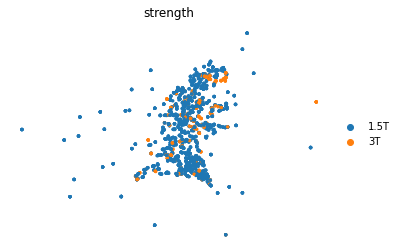

In [20]:
to_view = ["strength", "manufac", "DIAGNOSIS", "AGE"]
plot_pca_umap(adata, "raw", 0.02, color = to_view)
plot_pca_umap(adata, "combat", 0.02, color = to_view)
plot_pca_umap(adata, "covbat", 0.02, color = to_view)
plot_pca_umap(adata, "scvi_posterior", 0.02, color = to_view)

In [45]:
np.savetxt("scvi_posterior.csv", adata.layers["scvi_posterior"], delimiter=",")
np.savetxt("combat_scvi.csv", adata.layers["combat_scvi"], delimiter=",")
np.savetxt("scvi_combat.csv", adata.layers["scvi_combat"], delimiter=",")
np.savetxt("combat.csv", adata.layers["combat"], delimiter=",")
np.savetxt("covbat.csv", adata.layers["covbat"], delimiter=",")
np.savetxt("raw.csv", adata.layers["raw"], delimiter=",")
adata.obs.to_csv("covariates.csv")
np.savetxt("scvi_latent.csv", adata.obsm["scvi"], delimiter=",")

In [99]:
raw_scvi_corr = pd.DataFrame(np.corrcoef(adata.X, adata.layers["scvi_posterior"])[2515:, :2515])

In [115]:
raw_scvi_corr.columns = adni_all["subid"]
raw_scvi_corr.set_axis(adni_all["subid"], axis = 0, inplace = True)

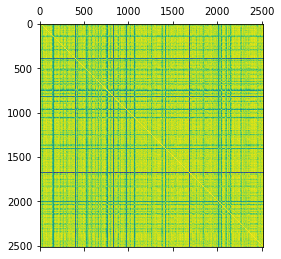

In [117]:
plt.matshow(raw_scvi_corr)

In [118]:
corr_pairs = raw_scvi_corr.unstack()

In [166]:
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)

In [168]:
sorted_pairs_df = pd.DataFrame(sorted_pairs)

(array([3.300000e+01, 5.400000e+01, 1.630000e+02, 4.440000e+02,
        1.024000e+03, 2.052000e+03, 3.799000e+03, 6.222000e+03,
        8.747000e+03, 1.056900e+04, 1.301300e+04, 1.601100e+04,
        1.871700e+04, 2.153500e+04, 2.419900e+04, 2.948300e+04,
        3.821500e+04, 5.065900e+04, 6.730700e+04, 8.981600e+04,
        1.196080e+05, 1.619740e+05, 2.338050e+05, 3.641190e+05,
        5.982240e+05, 9.355320e+05, 1.331823e+06, 1.463503e+06,
        6.857220e+05, 2.885300e+04]),
 array([-0.1293624 , -0.09183872, -0.05431504, -0.01679136,  0.02073232,
         0.058256  ,  0.09577967,  0.13330335,  0.17082703,  0.20835071,
         0.24587439,  0.28339807,  0.32092175,  0.35844542,  0.3959691 ,
         0.43349278,  0.47101646,  0.50854014,  0.54606382,  0.5835875 ,
         0.62111118,  0.65863485,  0.69615853,  0.73368221,  0.77120589,
         0.80872957,  0.84625325,  0.88377693,  0.9213006 ,  0.95882428,
         0.99634796]),
 <BarContainer object of 30 artists>)

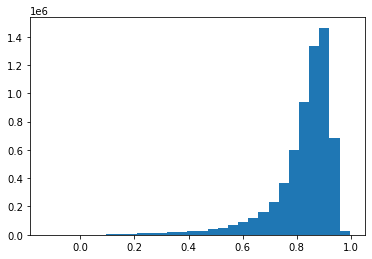

In [125]:
plt.hist(sorted_pairs, bins = 30)

In [132]:
unique_counts = np.unique(adni_all["subid"], return_counts=True)[1]

In [134]:
n_high_corrs = np.sum(unique_counts**2)
n_high_corrs

10447